In [21]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
PROJECT_ROOT = Path.cwd().resolve().parents[1]
sys.path.append(str(PROJECT_ROOT))
print("Loaded project root:", PROJECT_ROOT)

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm
from src.dataset import DeepPHQDataset, build_vocab, create_balanced_dataloader, split_by_pid
from models.lstm.lstm_model import DeepPHQLSTM 
import yaml


from models.text_cnn.utils import train, evaluate, set_seed, plot_curves
from models.text_cnn import TextCNN
from models.text_cnn import embeddings

# Load config
CONFIG_PATH = Path("cnn_config_curr.yaml") 

with open(CONFIG_PATH, "r") as f:
    config = yaml.safe_load(f)

config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded project root: C:\Users\wange\Documents\Classes\Deep Learning\DeepPHQ


{'data': {'level': 'word',
  'data_root': '../../data/processed',
  'word_csv': 'word_level.csv',
  'sentence_csv': 'sentence_level.csv',
  'dialogue_csv': 'dialogue_level.csv',
  'max_length': 512},
 'vocab': {'min_freq': 1, 'pad_token': '<PAD>', 'unk_token': '<UNK>'},
 'dataloader': {'batch_size': 32, 'num_workers': 2},
 'model': {'pretrained_embedding': True,
  'embeddings_file': 'glove_wiki50/wiki_giga_2024_50_MFT20_vectors_seed_123_alpha_0.75_eta_0.075_combined.txt',
  'embeddings_dim': 50,
  'num_filters': 8,
  'kernel_sizes': [3, 4, 5],
  'dropout': 0.1},
 'training': {'device': 'cuda',
  'num_epochs': 10,
  'learning_rate': '3e-4',
  'weight_decay': '1e-5',
  'gradient_clip': 1.0,
  'seed': 2025},
 'checkpoint': {'save_dir': '../../models/checkpoints',
  'filename': 'deepphq_cnn.pt'}}

In [2]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


In [20]:
data_cfg = config["data"]
root = Path(data_cfg["data_root"])

level = data_cfg["level"]

if level == "word":
    csv_path = root / data_cfg["word_csv"]
elif level == "sentence":
    csv_path = root / data_cfg["sentence_csv"]
elif level == "dialogue":
    csv_path = root / data_cfg["dialogue_csv"]
else:
    raise ValueError("Unknown level in config")

print("Loading:", csv_path)

df = pd.read_csv(csv_path)

all_texts = df["Text"].tolist()
vocab = build_vocab(all_texts, min_freq=config["vocab"]["min_freq"])

df.head()

Loading: ..\..\data\processed\word_level.csv
Vocab size = 8263


,PID,Text,PHQ_Score
0,300,out i playing me on done opportunities lot i w...,2
1,300,am i break no next i whatever alright done hig...,2
2,300,would the and they've diploma it bye parents n...,2
3,300,back someone games know probably school down b...,2
4,300,about friendship don't um annoying be out righ...,2


In [4]:
seed = config.get("training", {}).get("seed", 42)
set_seed(seed)
print(f"Seed set to {seed}")

# 1. split
train_df, val_df, test_df = split_by_pid(df)

# 2. create datasets
train_dataset = DeepPHQDataset(
    data=list(zip(train_df["PID"], train_df["Text"], train_df["PHQ_Score"])),
    vocab=vocab,
    max_length=config["data"]["max_length"]
)

val_dataset = DeepPHQDataset(
    data=list(zip(val_df["PID"], val_df["Text"], val_df["PHQ_Score"])),
    vocab=vocab,
    max_length=config["data"]["max_length"]
)

test_dataset = DeepPHQDataset(
    data=list(zip(test_df["PID"], test_df["Text"], test_df["PHQ_Score"])),
    vocab=vocab,
    max_length=config["data"]["max_length"]
)

# 3. dataloaders
train_loader = create_balanced_dataloader(
    train_dataset,
    batch_size=config["dataloader"]["batch_size"]
)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 4. verify shapes
batch = next(iter(train_loader))
print(batch["input_ids"].shape)
print(batch["label"].shape)
print(batch["pid"].shape)

Seed set to 2025
torch.Size([32, 512])
torch.Size([32])
torch.Size([32])


In [4]:
'''
# Turn the chunks generated above into train split datasets
from src import dataset_builder

df = pd.DataFrame(dataset_word, columns=["PID",'Text', 'PHQ_Score'])
normed_scores, score_mean, score_std = dataset_builder.normalize_scores(df["PHQ_Score"])
word_train, word_test, vocab = dataset_builder.preprocess_data(df["Text"], normed_scores)
'''

Score normalization:
  Original: mean=1.01, std=4.72, range=[-1.00, 22.00]
  Normalized: mean=0.00, std=1.00, range=[-0.42, 4.45]
Preprocessing 3740 samples
Train size: 2805, Test size: 935
Vocabulary size: 8218
Train dataset size: 2805
Test dataset size: 935


In [6]:

if config["model"]["pretrained_embedding"] == True:
    embeddings_file = config["model"]["embeddings_file"]
    embedding_matrix = embeddings.create_embedding_matrix(embeddings_file, vocab, config["model"]["embeddings_dim"])


Loading embeddings from glove_wiki50/wiki_giga_2024_50_MFT20_vectors_seed_123_alpha_0.75_eta_0.075_combined.txt...
Loaded 1287614 word vectors (dimension: 50)
Building embedding matrix for vocabulary size: 8263
Found embeddings for 7773/8263 words (94.1%)


In [22]:
model_config = config["model"]


if model_config["pretrained_embedding"] == True:
    cnn_model = TextCNN.CNNTextRegressor(len(vocab), embedding_dim = model_config["embeddings_dim"], kernel_sizes = model_config["kernel_sizes"], num_filters = model_config["num_filters"], dropout_rate = model_config["dropout"], pretrained_embedding = True, embedding_matrix = embedding_matrix, freeze_embeddings = False)
else:
    cnn_model = TextCNN.CNNTextRegressor(len(vocab), embedding_dim = model_config["embeddings_dim"], kernel_size = model_config["kernel_sizes"], num_filters = model_config["num_filters"], dropout_rate = model_config["dropout"], pretrained_embedding = False)

    
criterion = nn.MSELoss()  # Mean Squared Error for regression

optimizer = torch.optim.Adam(
    cnn_model.parameters(),
    lr=float(config["training"]["learning_rate"]),
    weight_decay=float(config["training"]["weight_decay"])
)

history = train(cnn_model, criterion, optimizer, train_loader, val_loader, epochs=config["training"]["num_epochs"], gradient_clip=config["training"]["gradient_clip"])
results = evaluate(cnn_model, test_loader)

#print(results)


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 58.49it/s]


Epoch 1/10
  Train Loss: 100.6439, Train MAE: 7.9439
  Val Loss: 16.4167, Val MAE: 2.6942
--------------------------------------------------


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 59.21it/s]


Epoch 2/10
  Train Loss: 94.2229, Train MAE: 7.5958
  Val Loss: 16.5237, Val MAE: 2.7452
--------------------------------------------------


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 60.38it/s]


Epoch 3/10
  Train Loss: 98.7585, Train MAE: 7.8078
  Val Loss: 16.5475, Val MAE: 2.7553
--------------------------------------------------


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 60.10it/s]


Epoch 4/10
  Train Loss: 98.0350, Train MAE: 7.7407
  Val Loss: 16.5566, Val MAE: 2.7590
--------------------------------------------------


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 60.07it/s]


Epoch 5/10
  Train Loss: 97.4092, Train MAE: 7.7037
  Val Loss: 16.5609, Val MAE: 2.7607
--------------------------------------------------


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 60.33it/s]


Epoch 6/10
  Train Loss: 91.7217, Train MAE: 7.4728
  Val Loss: 16.5633, Val MAE: 2.7617
--------------------------------------------------


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 59.79it/s]


Epoch 7/10
  Train Loss: 97.6224, Train MAE: 7.7287
  Val Loss: 16.5649, Val MAE: 2.7623
--------------------------------------------------


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 58.27it/s]


Epoch 8/10
  Train Loss: 96.9960, Train MAE: 7.7007
  Val Loss: 16.5659, Val MAE: 2.7626
--------------------------------------------------


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 60.27it/s]


Epoch 9/10
  Train Loss: 97.3720, Train MAE: 7.7317
  Val Loss: 16.5667, Val MAE: 2.7629
--------------------------------------------------


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 60.24it/s]


Epoch 10/10
  Train Loss: 94.4975, Train MAE: 7.6632
  Val Loss: 16.5672, Val MAE: 2.7631
--------------------------------------------------
Loaded best model weights


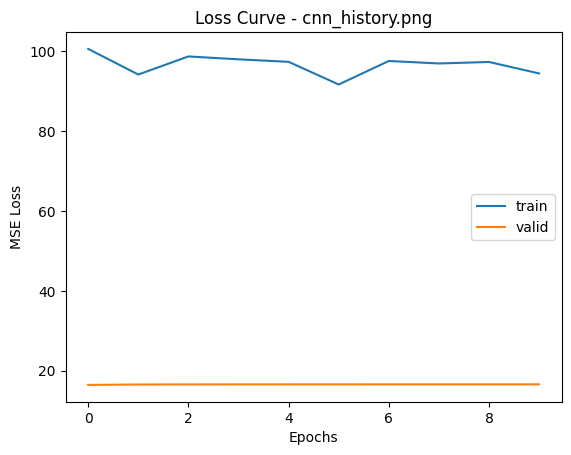

In [23]:
results = evaluate(cnn_model, test_loader)
plot_curves(history["train_loss"], history["val_loss"], "cnn_history.png")